In [ ]:
# https://sites.google.com/view/tmarchetti/research
# 7Million stars w/ good parallaxes and have RVs, so we can use the
# 6D phase space distribution (XYZ positions + 3D velocities)

# Does this change our approach or defition? I dunno, let's see what we find...

# this sample is ~20x larger than the GCNS sample, so should be very easy for KDTree still
# if we want to do ~1B stars, that's another factor of +100X we need to increase the sample.
# but if we limit to stars w/ "good distances", maybe that will get us down to only 10x larger still!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import astropy.units as u
import astropy.coordinates as coord
from sklearn.neighbors import KDTree

from astropy.table import Table
import sys
# sys.path.append('/Users/james/python/qthist2d/')
# from qthist2d import qthist, qtcount

sys.path.append('/Users/james/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [5]:
file = 'GaiaEDR3_vrad_lowf_vel_0.2.fits'
v7M = Table.read(file, format='fits')

In [17]:
v7M.colnames

['source_id',
 'ra',
 'dec',
 'parallax',
 'e_parallax',
 'pmra',
 'e_pmra',
 'pmdec',
 'e_pmdec',
 'corr_parallax_pmra',
 'corr_parallax_pmdec',
 'corr_pmra_pmdec',
 'vrad',
 'e_vrad',
 'GMag',
 'BPMag',
 'RPMag',
 'RUWE',
 'rv_nb_transits',
 'dist',
 'el_dist',
 'eu_dist',
 'rGC',
 'el_rGC',
 'eu_rGC',
 'RGC',
 'el_RGC',
 'eu_RGC',
 'xGC',
 'el_xGC',
 'eu_xGC',
 'yGC',
 'el_yGC',
 'eu_yGC',
 'zGC',
 'el_zGC',
 'eu_zGC',
 'U',
 'el_U',
 'eu_U',
 'V',
 'el_V',
 'eu_V',
 'W',
 'el_W',
 'eu_W',
 'UW',
 'el_UW',
 'eu_UW',
 'vR',
 'el_vR',
 'eu_vR',
 'vphi',
 'el_vphi',
 'eu_vphi',
 'vtot',
 'el_vtot',
 'eu_vtot',
 'P_ub']

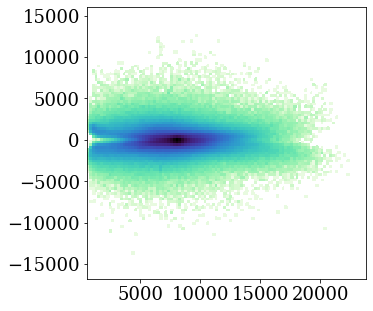

In [13]:
CMAP = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)

plt.figure(figsize=(5,5))
_ = plt.hist2d(v7M['RGC'], v7M['zGC'], cmap=CMAP, bins=100, norm=LogNorm())

In [37]:
sum(v7M['dist'] < 100)

72629

In [15]:
X = np.vstack((v7M['xGC'], v7M['yGC'], v7M['zGC'])).T
X.shape

(6969738, 3)

In [16]:
tree = KDTree(X)
dist, ind = tree.query(X, k=2)
dist.shape

(6969738, 2)

In [55]:
def medbin(x,y,nbins=50, std=True):
    xbin0 = np.linspace(np.nanmin(x), np.nanmax(x), nbins)
    ybin = np.zeros(nbins-1)
    xbin = np.zeros(nbins-1)
    if std:
        ystd = np.zeros(nbins-1)
        xstd = np.zeros(nbins-1)

    for k in range(len(xbin0)-1):
        kind = np.where((x >= xbin0[k]) & (x < xbin0[k+1]))[0]
        if len(kind) > 0:
            ybin[k] = np.median(y[kind])
            xbin[k] = np.median(x[kind])
            if std:
                ystd[k] = np.std(y[kind])
                xstd[k] = np.std(x[kind])
    if std:
        return xbin,ybin,xstd,ystd
    return xbin,ybin

(0.0, 4.0)

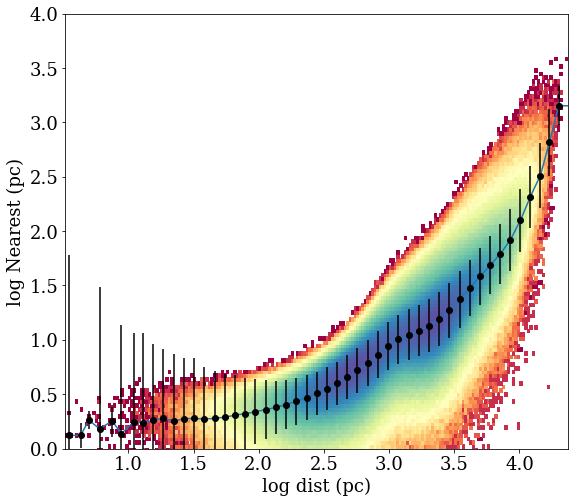

In [65]:
plt.figure(figsize=(9,8))
_ = plt.hist2d(np.log10(v7M['dist']), np.log10(dist[:,1]), bins=200, cmap=plt.cm.Spectral, norm=LogNorm())

xbin,ybin,xstd,ystd = medbin(np.log10(v7M['dist']), np.log10(dist[:,1]), nbins=50, std=True)
plt.errorbar(xbin,ybin, yerr=ystd,c='k', linestyle='none',marker='o',label='Median+/-StdDev')

dcor = np.interp(np.log10(v7M['dist']), xbin,ybin)
ds = np.argsort(np.log10(v7M['dist']))
plt.plot(np.log10(v7M['dist'])[ds], dcor[ds])

plt.xlabel('log dist (pc)')
plt.ylabel('log Nearest (pc)')
plt.ylim(0,4)

(0.0, 4.0)

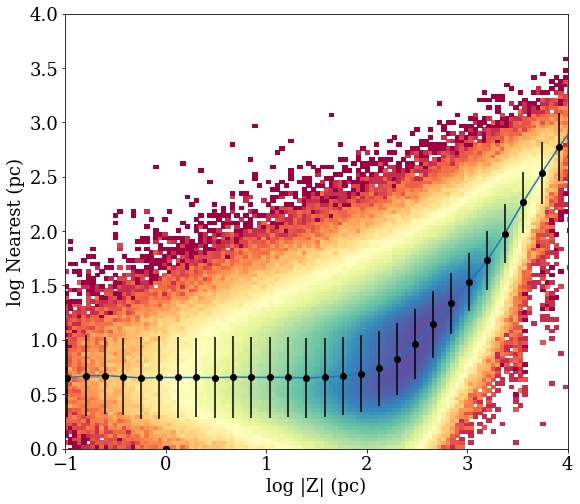

In [70]:
plt.figure(figsize=(9,8))
_ = plt.hist2d(np.log10(np.abs(v7M['zGC'])), np.log10(dist[:,1]), bins=200, cmap=plt.cm.Spectral, norm=LogNorm())

xbin,ybin,xstd,ystd = medbin(np.log10(np.abs(v7M['zGC'])), np.log10(dist[:,1]), nbins=50, std=True)
plt.errorbar(xbin,ybin, yerr=ystd,c='k', linestyle='none',marker='o',label='Median+/-StdDev')

zcor = np.interp(np.log10(np.abs(v7M['zGC'])), xbin,ybin)
ds = np.argsort(np.log10(np.abs(v7M['zGC'])))
plt.plot(np.log10(np.abs(v7M['zGC']))[ds], zcor[ds])


plt.xlabel('log |Z| (pc)')
plt.ylabel('log Nearest (pc)')
plt.xlim(-1,4)
plt.ylim(0,4)

(-1.0, 4.0)

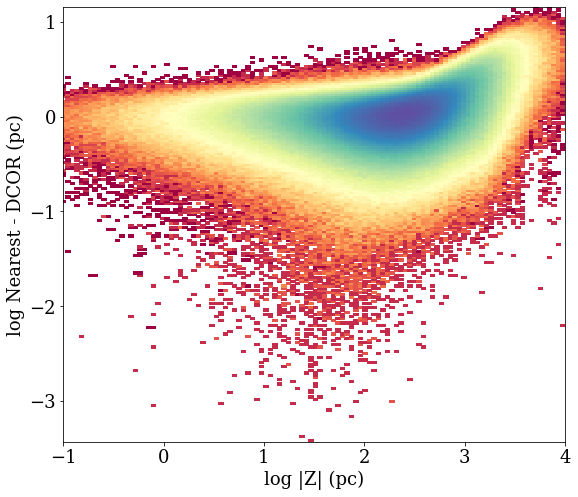

In [69]:
plt.figure(figsize=(9,8))
_ = plt.hist2d(np.log10(np.abs(v7M['zGC'])), np.log10(dist[:,1]) - dcor, 
               bins=200, cmap=plt.cm.Spectral, norm=LogNorm())

# xbin,ybin,xstd,ystd = medbin(np.log10(np.abs(v7M['zGC'])), np.log10(dist[:,1]), nbins=50, std=True)
# plt.errorbar(xbin,ybin, yerr=ystd,c='k', linestyle='none',marker='o',label='Median+/-StdDev')

plt.xlabel('log |Z| (pc)')
plt.ylabel('log Nearest - DCOR (pc)')
plt.xlim(-1,4)
# plt.ylim(0,4)

Text(0, 0.5, 'log Nearest-ZCOR (pc)')

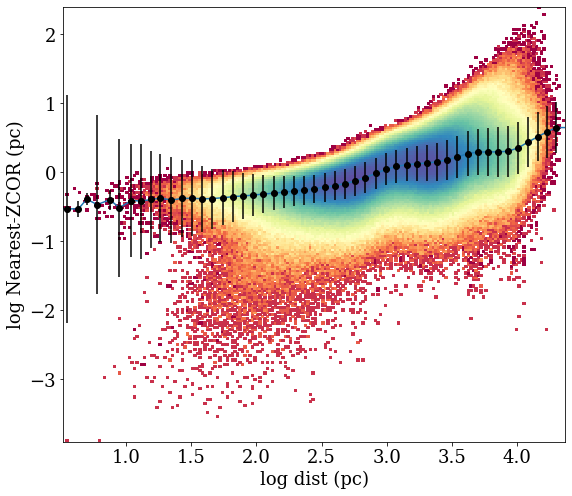

In [80]:
plt.figure(figsize=(9,8))
_ = plt.hist2d(np.log10(v7M['dist']), np.log10(dist[:,1])-zcor, bins=200, cmap=plt.cm.Spectral, norm=LogNorm())

xbin,ybin,xstd,ystd = medbin(np.log10(v7M['dist']), np.log10(dist[:,1])-zcor, nbins=50, std=True)
plt.errorbar(xbin,ybin, yerr=ystd,c='k', linestyle='none',marker='o',label='Median+/-StdDev')

zdcor = np.interp(np.log10(v7M['dist']), xbin,ybin)
ds = np.argsort(np.log10(v7M['dist']))
plt.plot(np.log10(v7M['dist'])[ds], zdcor[ds])
plt.xlabel('log dist (pc)')
plt.ylabel('log Nearest-ZCOR (pc)')

Text(0, 0.5, 'log Nearest -ZCOR-ZDCOR (pc)')

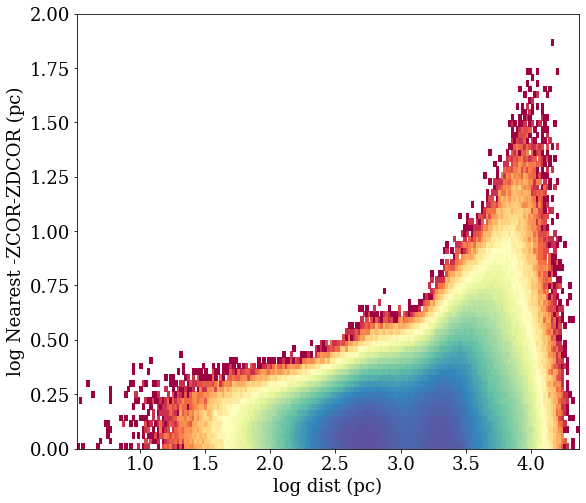

In [81]:

plt.figure(figsize=(9,8))
_ = plt.hist2d(np.log10(v7M['dist']), np.log10(dist[:,1])-zcor-zdcor, bins=200, 
               cmap=plt.cm.Spectral, norm=LogNorm())

plt.ylim(0,2)
plt.xlabel('log dist (pc)')
plt.ylabel('log Nearest -ZCOR-ZDCOR (pc)')

In [62]:
np.mean(dist[(v7M['dist'] < 100), 1])

2.0277025861733478

In [64]:
np.mean(dist[(np.abs(v7M['zGC']) < 10),1])

6.787994844528478